## 로지스틱 회귀

In [9]:
import numpy as np
import pandas
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [10]:
df = web.DataReader("SPY", data_source="yahoo", start="2016-01-01", end="2020-01-01")[["Open", "High", "Low", "Close"]]
df.dropna()

,Open,High,Low,Close
Date,,,,
2015-12-31,205.130005,205.889999,203.869995,203.869995
2016-01-04,200.490005,201.029999,198.589996,201.020004
2016-01-05,201.399994,201.899994,200.050003,201.360001
2016-01-06,198.339996,200.059998,197.600006,198.820007
2016-01-07,195.330002,197.440002,193.589996,194.050003
...,...,...,...,...
2019-12-24,321.470001,321.519989,320.899994,321.230011
2019-12-26,321.649994,322.950012,321.640015,322.940002
2019-12-27,323.739990,323.799988,322.279999,322.859985


In [11]:
df["MA10"] = df["Close"].rolling(window=10).mean()
df["Corr"] = df["Close"].rolling(window=10).corr(df["MA10"])
df["Open-Close"] = df["Open"]-df["Close"].shift(1)
df["Open-Open"] = df["Open"]-df["Open"].shift(1)
df = df.dropna()

In [12]:
X = df[["Open", "High", "Low", "Close", "MA10", "Corr", "Open-Close", "Open-Open"]]
y = np.where(df["Close"].shift(-1) > df["Close"], 1, -1)

In [13]:
train_pct = 0.8
split = int(train_pct*len(df))

X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [14]:
model = LogisticRegression()
model.fit(X_train, y_train)

pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))  # 회귀계수

,0,1
0,Open,[0.09829621635388419]
1,High,[-0.10239564419705273]
2,Low,[-0.11500607744143738]
3,Close,[0.10160301356248148]
4,MA10,[0.018115862092325487]
5,Corr,[-0.0794015858190892]
6,Open-Close,[-0.05395492509794745]
7,Open-Open,[0.021809805658764066]


In [16]:
probability = model.predict_proba(X_test)
print(probability[:5])

predicted = model.predict(X_test)
print(predicted[:5])

[[0.46249029 0.53750971]
 [0.42293793 0.57706207]
 [0.44230258 0.55769742]
 [0.43533791 0.56466209]
 [0.39621264 0.60378736]]
[1 1 1 1 1]


In [17]:
print(metrics.confusion_matrix(y_test, predicted))

[[  3  82]
 [  1 112]]


In [20]:
print(metrics.classification_report(y_test, predicted))
print(model.score(X_test, y_test))

# acc : 58%

              precision    recall  f1-score   support

          -1       0.75      0.04      0.07        85
           1       0.58      0.99      0.73       113

    accuracy                           0.58       198
   macro avg       0.66      0.51      0.40       198
weighted avg       0.65      0.58      0.45       198

0.5808080808080808


In [22]:
# 매매전략

df["Signal"] = model.predict(X)
df["SPY_Returns"] = np.log(df["Close"] / df["Close"].shift(1))  # SNP 일간수익률
Cum_SPY_Returns = np.cumsum(df[split:]["SPY_Returns"])  # SNP 누적수익률

df["STR_Returns"] = df["SPY_Returns"] * df["Signal"].shift(1)
Cum_STR_Returns = np.cumsum(df[split:]["STR_Returns"])

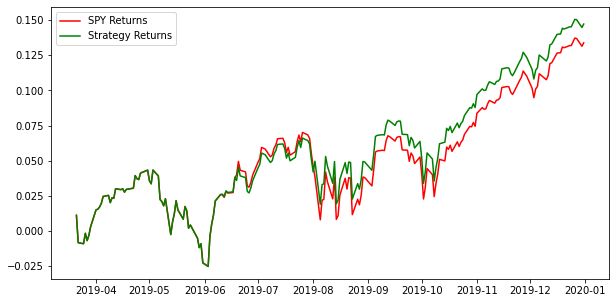

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(Cum_SPY_Returns, color='r', label="SPY Returns")
plt.plot(Cum_STR_Returns, color='g', label="Strategy Returns")
plt.legend()
plt.show()

# SNP보다 조금 더 좋은 수익률을 보임

In [25]:
# 샤프비율 계산
Std= Cum_STR_Returns.std()

Sharpe = (Cum_STR_Returns - Cum_SPY_Returns)/Std
Sharpe = Sharpe.mean()
print("Sharpe ratio :", Sharpe)

# 샤프비율이 양수로 나타남

Sharpe ratio : 0.14467613312009947
